2024-11-10 18:56:09.169615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 18:56:10.769310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 18:56:10.772888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1375/1375 [==============================] - 7s 4ms/step


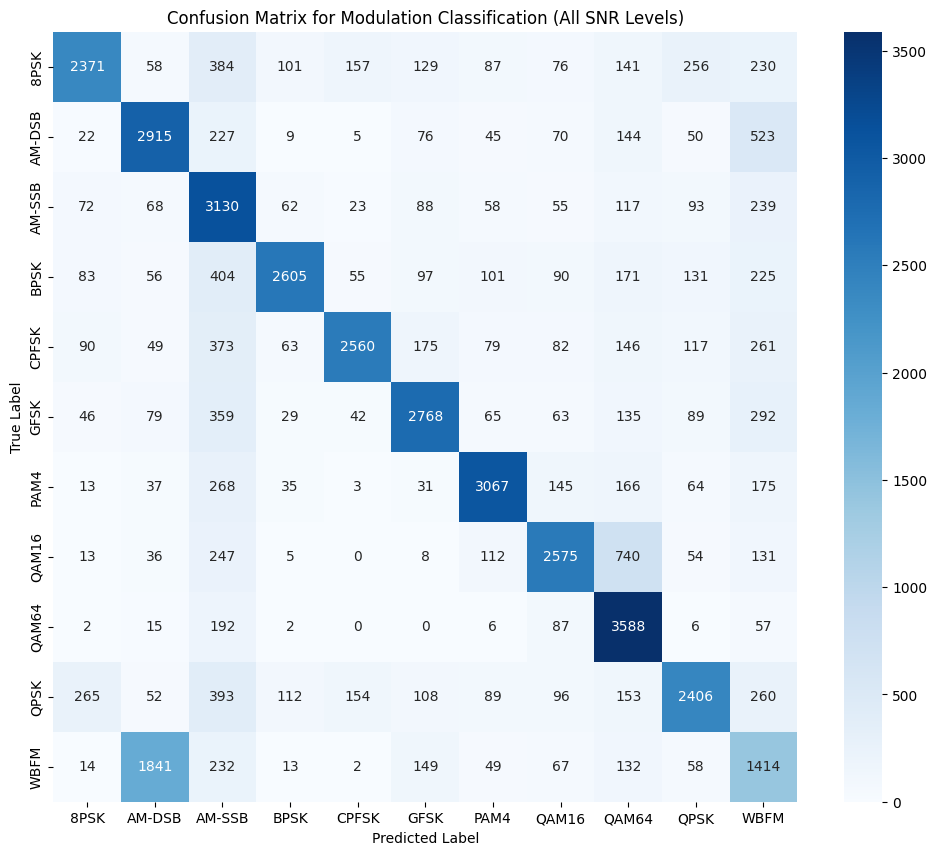

Classification Report for Modulation Types:
              precision    recall  f1-score   support

        8PSK       0.79      0.59      0.68      3990
      AM-DSB       0.56      0.71      0.63      4086
      AM-SSB       0.50      0.78      0.61      4005
        BPSK       0.86      0.65      0.74      4018
       CPFSK       0.85      0.64      0.73      3995
        GFSK       0.76      0.70      0.73      3967
        PAM4       0.82      0.77      0.79      4004
       QAM16       0.76      0.66      0.70      3921
       QAM64       0.64      0.91      0.75      3955
        QPSK       0.72      0.59      0.65      4088
        WBFM       0.37      0.36      0.36      3971

    accuracy                           0.67     44000
   macro avg       0.69      0.67      0.67     44000
weighted avg       0.69      0.67      0.67     44000



2024-11-10 18:56:24.064055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-10 18:56:24.065428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-10 18:56:24.066254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

480/480 [==============================] - 2s 4ms/step


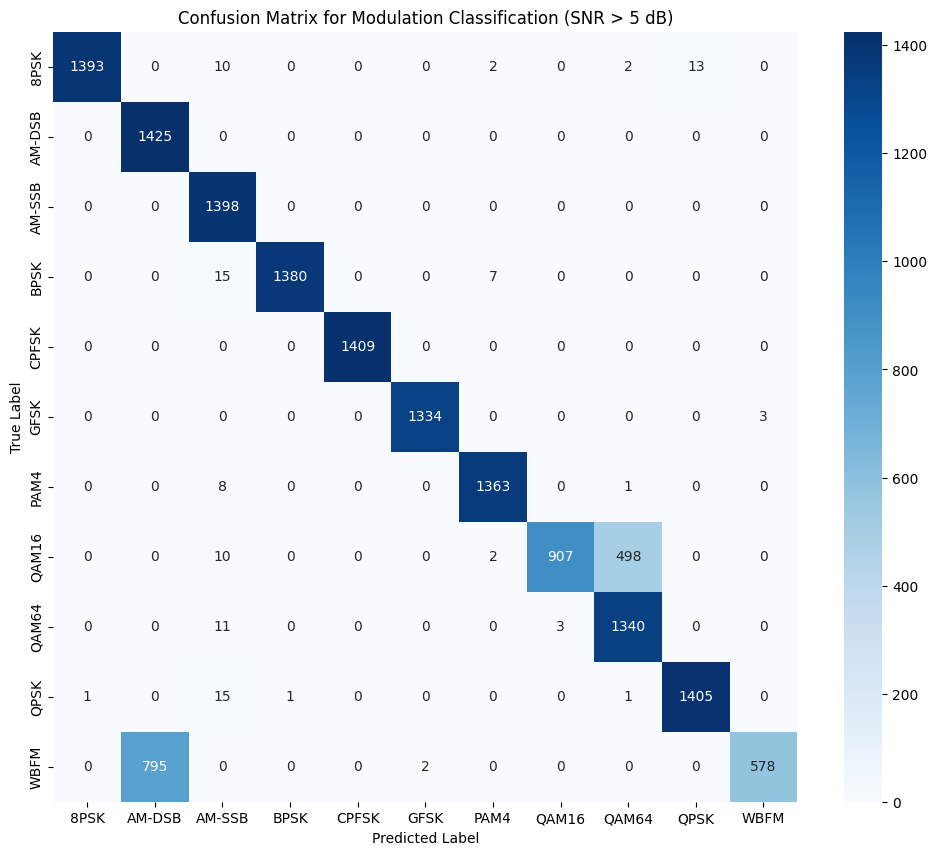

Classification Report for Modulation Types (SNR > 5 dB):
              precision    recall  f1-score   support

        8PSK       1.00      0.98      0.99      1420
      AM-DSB       0.64      1.00      0.78      1425
      AM-SSB       0.95      1.00      0.98      1398
        BPSK       1.00      0.98      0.99      1402
       CPFSK       1.00      1.00      1.00      1409
        GFSK       1.00      1.00      1.00      1337
        PAM4       0.99      0.99      0.99      1372
       QAM16       1.00      0.64      0.78      1417
       QAM64       0.73      0.99      0.84      1354
        QPSK       0.99      0.99      0.99      1423
        WBFM       0.99      0.42      0.59      1375

    accuracy                           0.91     15332
   macro avg       0.94      0.91      0.90     15332
weighted avg       0.94      0.91      0.90     15332



In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Load the pre-trained RNN/LSTM model
model_path = "../src/ml_wireless_classification/models/rnn_lstm_w_SNR.keras"
model = load_model(model_path)

# Load the data
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Prepare the data using your specific format
def prepare_data(data):
    X, y = [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = np.vstack([signal[0], signal[1]]).T
            snr_signal = np.full((128, 1), snr)
            combined_signal = np.hstack([iq_signal, snr_signal])
            X.append(combined_signal)
            y.append(mod_type)

    X = np.array(X)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])

    return X_train, X_test, y_train, y_test, label_encoder

# Prepare the data
X_train, X_test, y_train, y_test, label_encoder = prepare_data(data)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Plot the confusion matrix for all SNR levels
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (All SNR Levels)")
plt.show()

# Print the classification report
print("Classification Report for Modulation Types:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot feature importance (if using a tree-based model)
# Plot confusion matrix for SNR > 5 dB subset
snr_above_5_indices = np.where(X_test[:, 0, 2] > 5)  # Assuming SNR values are in the third column
X_test_snr_above_5 = X_test[snr_above_5_indices]
y_test_snr_above_5 = y_test[snr_above_5_indices]

# Make predictions on the SNR > 5 dB subset
y_pred_snr_above_5 = np.argmax(model.predict(X_test_snr_above_5), axis=1)

# Plot confusion matrix for SNR > 5 dB
conf_matrix_snr_above_5 = confusion_matrix(y_test_snr_above_5, y_pred_snr_above_5)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_snr_above_5, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (SNR > 5 dB)")
plt.show()

# Print the classification report for SNR > 5 dB
print("Classification Report for Modulation Types (SNR > 5 dB):")
print(classification_report(y_test_snr_above_5, y_pred_snr_above_5, target_names=label_encoder.classes_))
